# `Занятие 7: Generative Adversarial Network (GAN)`

![](https://nbviewer.jupyter.org/github/hse-aml/intro-to-dl/blob/master/week4/images/gan.png)

Пришло время поговорить о более интересных архитектурах, а именно о GANах или состязательных нейронных сетках. [Впервые GANы были предложены в 2014 году.](https://arxiv.org/abs/1406.2661) Сейчас они очень активно исследуются. GANы состоят из двух нейронных сетей: 

* Первая - генератор порождает из некоторого заданного распределения случайные числа и собирает из них объекты, которые идут на вход второй сети. 
* Вторая - дискриминатор получает на вход объекты из реальной выборки и объекты, созданные генератором. Она пытается определить какой объект был порождён генератором, а какой является реальным.

Таким образом генератор пытается создавать объекты, которые дискриминатор не сможет отличить от реальных. 

### Цель
В этом ноутбуке мы создадим свой первый GAN, а именно мы построим и обучим GAN, который генерирует рукописные цифры.

### План
1.   Построить генератор и дискриминатор с нуля
2.   Написать лосс функции для генератора и дискриминатора
3.   Обучить GAN и визуализировать сгенерированные изображения
4.   Обучить  Deep Convolutional GAN (DCGAN), очень успешный GAN, созданный в 2015


### Совет
При обучении может возникнуть огромное количество пробем от взрыва весов до более тонких вещей. Имеет смысл посмотреть на [разные трюки](https://github.com/soumith/ganhacks), используемые при обучении.


In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), dcgan=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    if dcgan:
        image_tensor = (image_tensor + 1) / 2
        image_unflat = image_tensor.detach().cpu()
    else:
        image_unflat = image_tensor.detach().cpu().view(-1, *size)

    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
Изображения, которые будет использовать дискриминатор в качестве обучения, взяты из набора данных под названием [MNIST](http://yann.lecun.com/exdb/mnist/). Он содержит 60000 изображений рукописных цифр от 0 до 9, например:

In [4]:
from IPython.display import Image, clear_output

![img](https://camo.githubusercontent.com/a83a91881f3115a3635c51eb47824e9f94cd5de2e9331e7040bc2db9b9a11cd2/68747470733a2f2f6d61696e2e71636c6f7564696d672e636f6d2f7261772f34323633363162666339336138396136323262313764346435643439316362312f313536383137303032323433382e706e67)

Image('https://camo.githubusercontent.com/a83a91881f3115a3635c51eb47824e9f94cd5de2e9331e7040bc2db9b9a11cd2/68747470733a2f2f6d61696e2e71636c6f7564696d672e636f6d2f7261772f34323633363162666339336138396136323262313764346435643439316362312f313536383137303032323433382e706e67')

## Generator
Первым делом создадим генератор.

Начнем с создания функции для создания одного слоя/блока для нейронной сети генератора. Каждый блок состоит из линейного слоя, батч нормализации и, наконец, нелинейной функции активации.

In [5]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        #### END CODE HERE ####
        nn.ReLU(inplace=True)
    )

Теперь вы можете построить класс генератора. Он принимает на вход 3 значения:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST).  The final layer does not need a normalization or activation function, but does need to be scaled with a sigmoid function

Finally, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network.

In [6]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),

            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        '''
        return self.gen(noise)

## Noise
To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. You will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors at once.


In [7]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    return torch.randn((n_samples, z_dim)).to(device)
    #### END CODE HERE ####

## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.

*Note: You use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient*



In [8]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)  # inplace=True
        #### END CODE HERE ####
    )

Теперь используем написанную функцию для создания дискриминатора. Он принимает на вход 2 значения:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real.

You do not need a sigmoid after the output layer since it is included in the loss function **(BCEWithLogitsLoss)**. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [9]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        '''
        return self.disc(image)

## Training GAN
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



In [10]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = torch.device('cuda', 0)

Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. 

Remember to call `.detach()` on the generator result to ensure that only the discriminator is updated. This is important due to the fact that the generator is needed when calculating the discriminator's loss!


In [12]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device=device)
    fake = gen(noise).detach()
    
    pred_of_fake = disc(fake)
    loss_fake = criterion(pred_of_fake, torch.zeros_like(pred_of_fake))

    pred_of_real = disc(real)
    loss_real = criterion(pred_of_real, torch.ones_like(pred_of_real))
    
    disc_loss = (loss_fake + loss_real) / 2
    #### END CODE HERE ####
    return disc_loss

In [13]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real

    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device=device)
    fake = gen(noise)
    
    pred_of_fake = disc(fake)
    gen_loss = criterion(pred_of_fake, torch.ones_like(pred_of_fake))

    #### END CODE HERE ####
    return gen_loss

Finally, you can put everything together! 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN.

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes:

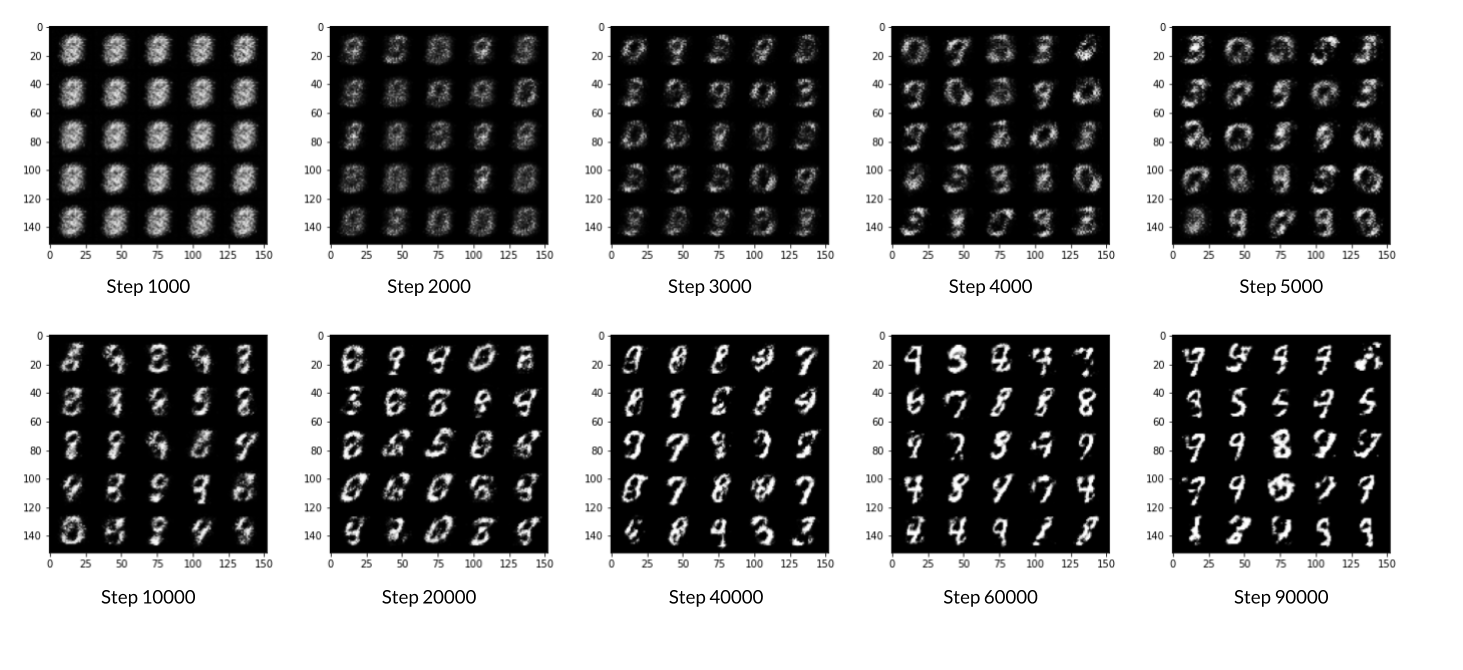

In [ ]:
Image('images/MNIST_res.png')

Step 92500: Generator loss: 1.2338, discriminator loss: 0.4972


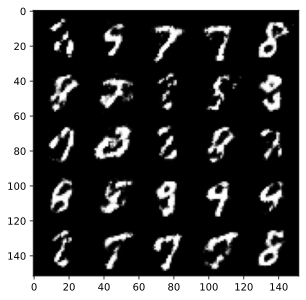

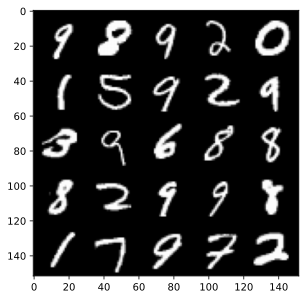

Step 93000: Generator loss: 1.2778, discriminator loss: 0.4736


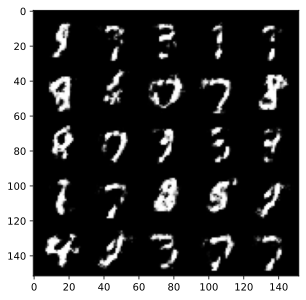

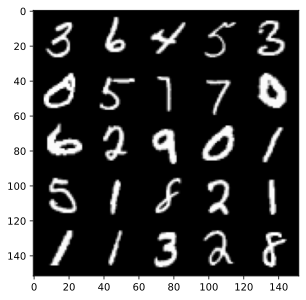

Step 93500: Generator loss: 1.3208, discriminator loss: 0.4690


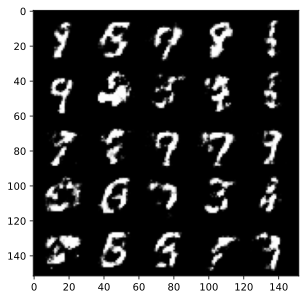

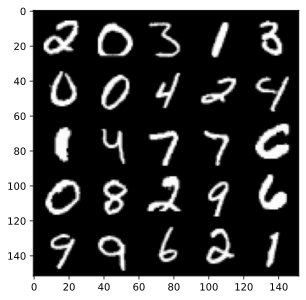

In [14]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
# gen_loss = False
for epoch in tqdm(range(n_epochs)):
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device) # Flatten the batch of real images from the dataset

        ### Update discriminator ###
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss:.4f}, discriminator loss: {mean_discriminator_loss:.4f}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            
        if cur_step % (4 * display_step) == 0 and cur_step > 0:
            clear_output()
            
        cur_step += 1

## DCGAN

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :)*

Ниже предтавлены основные особенности и советы по обучению стабильных DCGAN. Эти рекомендации взяты из статьи:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
* Use BatchNorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

![img](https://neerc.ifmo.ru/wiki/images/1/10/DCGAN_generator.png)

Напишем класс генератора

In [15]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

    
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

Напишем класс дискриминатора

In [16]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        #       Note: Don't use an activation on the final layer
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

Для DCGAN дополнительно зададим хорошо себя зарекомендовавшие параметры оптимайзера $\beta_1$ и $\beta_2$, а также инициализцируем веса

In [17]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002  # A learning rate of 0.0002 works well on DCGAN

# These parameters control the optimizer's momentum
beta_1 = 0.5 
beta_2 = 0.999
device = torch.device('cuda', 0)

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [18]:
beta_1 = 0.5 
beta_2 = 0.999

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse: 

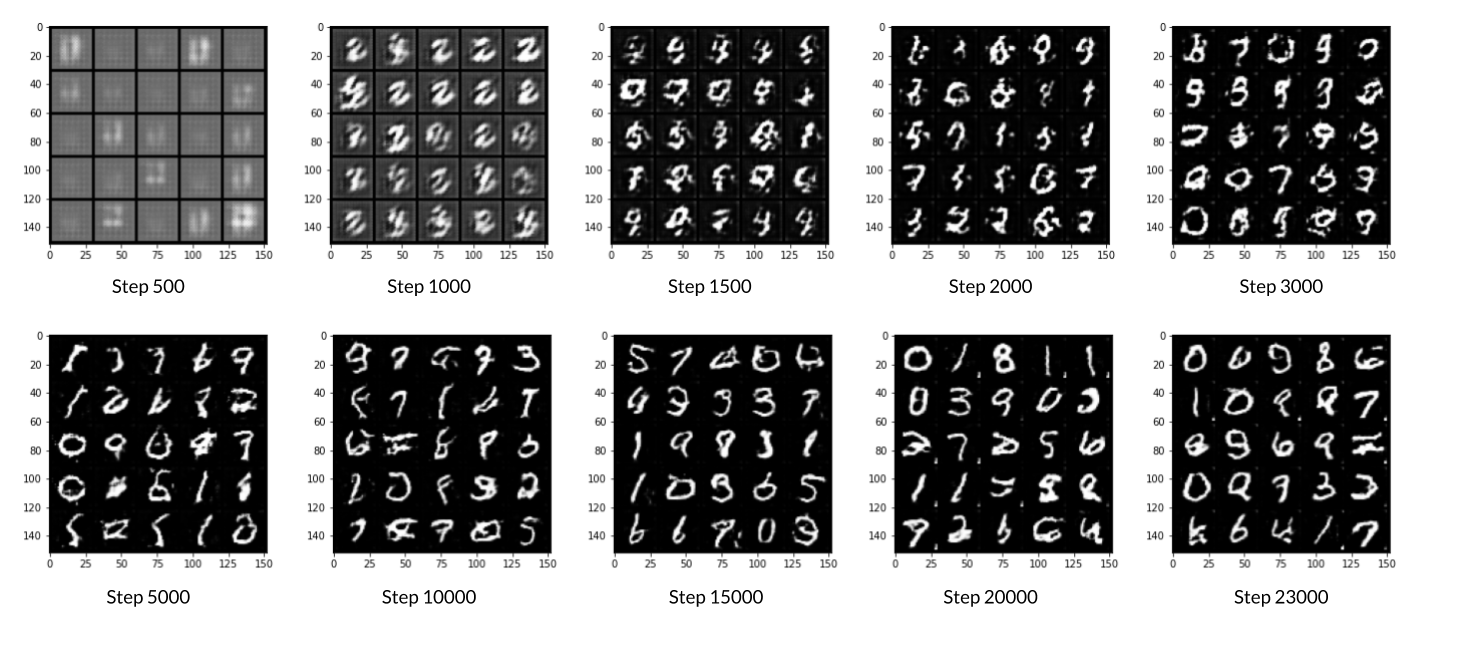

In [ ]:
Image('images/MNIST_DCGAN_Progression.png')

Epoch 47, step 22500: Generator loss: 0.7043, discriminator loss: 0.6947


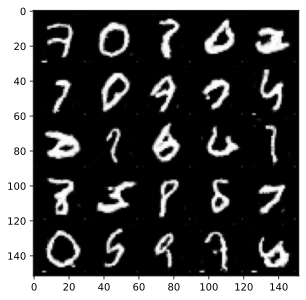

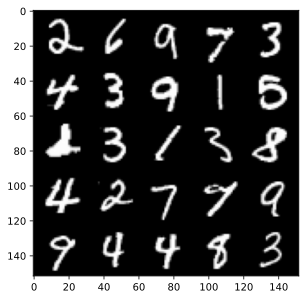

Epoch 49, step 23000: Generator loss: 0.7028, discriminator loss: 0.6945


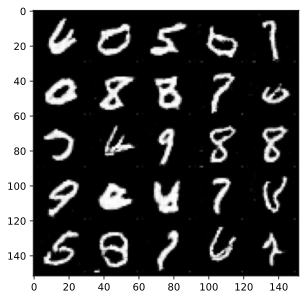

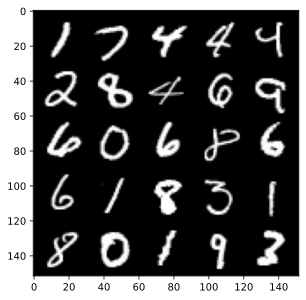

In [19]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in tqdm(range(n_epochs)):
    # Dataloader returns the batches
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss:.4f}, discriminator loss: {mean_discriminator_loss:.4f}")
            show_tensor_images(fake, dcgan=True)
            show_tensor_images(real, dcgan=True)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            
        if cur_step % (4 * display_step) == 0 and cur_step > 0:
            clear_output()
        
        cur_step += 1

The standard autoencoder can have an issue, constituted by the fact that the latent space can be irregular [1]. This means that close points in the latent space can produce different and meaningless patterns over visible units.

One solution to this issue is the introduction of the Variational Autoencoder. As the autoencoder, it is composed of two neural network architectures, encoder and decoder.